# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most influential figures during the pandemic – or did they? Will causal analyses of the effect of Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our goal is to study the impact an influential leader can have on information spread in a crisis with a focus on fake news, as an overload of misleading or contradictory statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis management. To provide a more comprehensive insight into Trump’s actual influence on online information spread, we would also like to compare it with that of other factors such as mobility restrictions or key milestones (e.g. first Covid death).

## Imports :

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data
- Import & describe (source, size, columns, etc -> similar to homework/tutorials) datasets used for this part
    - Datasets: DT tweets + Wikipedia pageviews
- Preprocess: format, missing values, filtering, transforming, enriching (cf. homework 1) 


Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present the Donald Trump's tweets dataset 

In [176]:
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [177]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
44104,913003340451188737,"With one Yes vote in hospital &amp, very posit...",f,f,Twitter for iPhone,45936,7920,2017-09-27,f
9783,1231372451893972993,“The Kremlin is reportedly backing Bernie Sand...,f,f,Twitter for iPhone,97616,21905,2020-02-23,f
42845,693171827363991553,They say that if I participated in last night’...,f,f,Twitter for iPhone,7191,2069,2016-01-29,f
43705,926789876556500992,"Unemployment is down to 4.1%, lowest in 17 yea...",f,f,Twitter for iPhone,136217,30564,2017-11-04,f
15516,257140638523486208,I'll bet Obama goes down just like Washington ...,f,f,Twitter Web Client,67,191,2012-10-13,f


There is no empty cell in the dataset :

In [178]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on covid period:

In [179]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Check if Donald Trump Tweeted every day

In [180]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


In [181]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

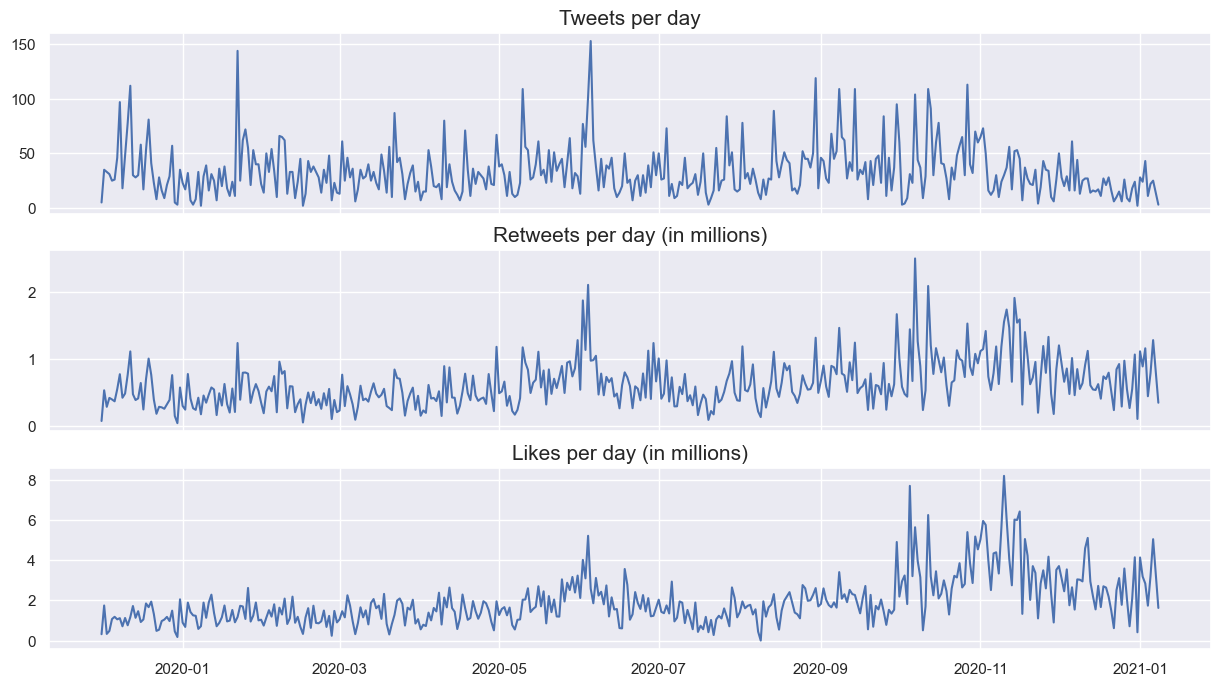

In [182]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

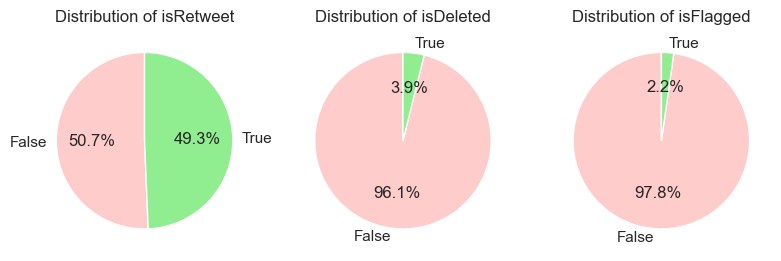

In [183]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though they can be an indication of misinformation from trump.

Let's focus on covid topics

In [184]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [185]:
#put all the text togheter
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

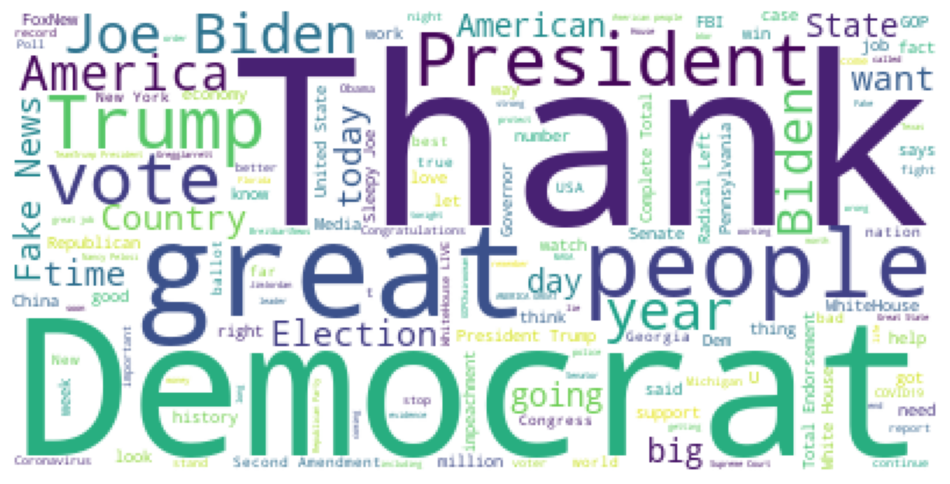

In [186]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

Let's focus our analysis on covid related tweets

In [202]:
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

False    12874
True       644
Name: covid_related, dtype: int64

In [203]:
data_covid_rel = data[data['covid_related']==1]

In [204]:
#put all the text togheter
result_text = ' '.join(data_covid_rel['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

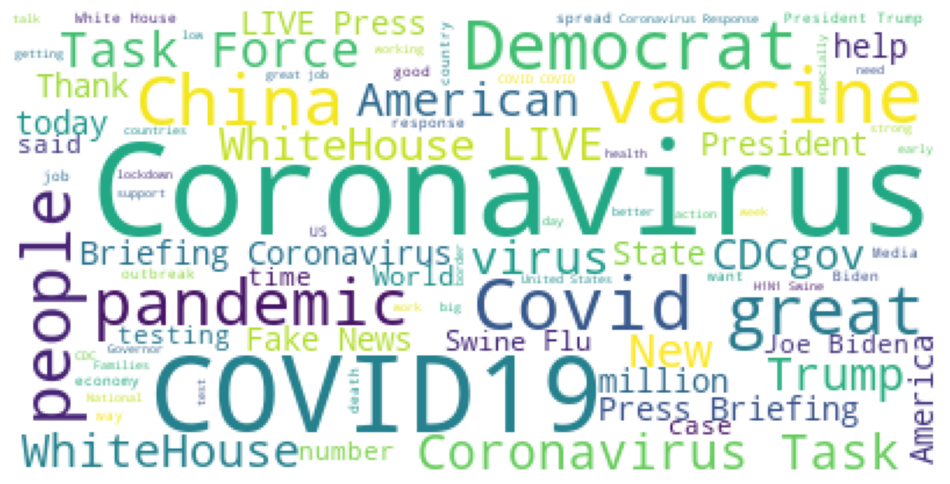

In [205]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

Find the moment when the topic is the most popular

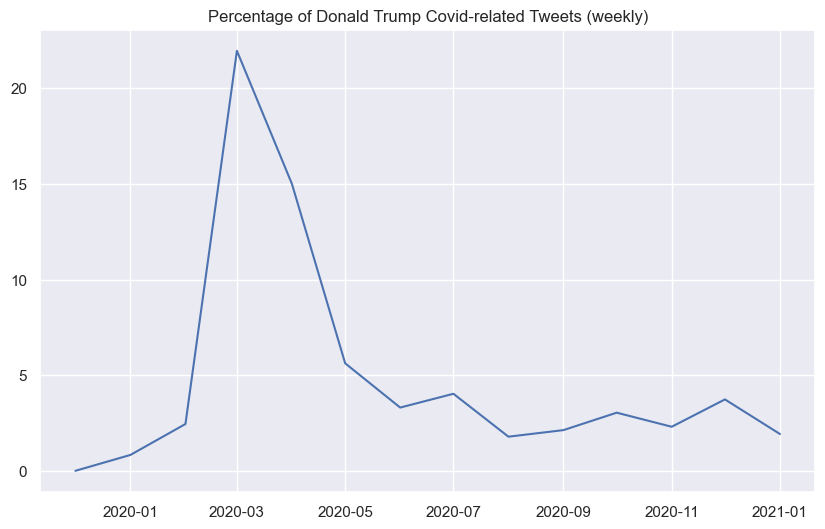

In [191]:
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid

In [192]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')


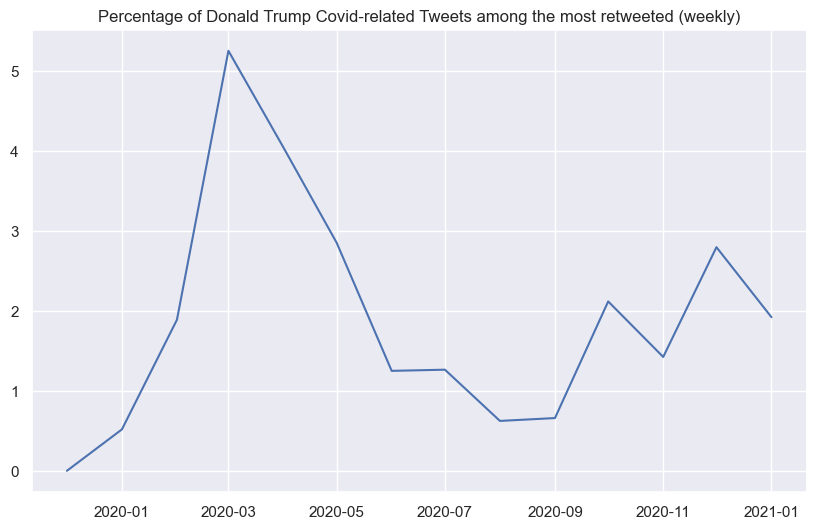

In [193]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

### B) We can now perform our first causal analyses
_Note:_ For every piece of analysis, we should briefly explain the theory/math (document this!), include visualizations & statistical tests and (optionally?) model training

__Proposed analysis pipeline__ for this part 1.B:
- Matteo's analysis leading to the very interesting Wikipedia pageviews - DT tweet plot
- Causal analysis with Google library (as we need the events - DT tweets - to know where to expect a causal effect): https://google.github.io/CausalImpact/CausalImpact.html
- Granger causality test: "Is Trump leading or following the trend?"
- Some model training (You think that's relevant? Ask Manoel?)

We now wnat to study fake news related Donald Trump tweets

In [194]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [195]:
trend_data = []

month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Load JSON data
with open('hydroxychloroquine_googletrends.json', 'r') as file:
    data_views = json.load(file)

    for date in data_views['interest_over_time']['timeline_data']:
        parts = date['date'].replace('–', ' '). replace(',', ' ').split()
        if len(parts) == 6:
            trend_data.append({'date': datetime(year=int(parts[2]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})
        else:
            trend_data.append({'date': datetime(year=int(parts[-1]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})

# Create DataFrame from the list
trend_df = pd.DataFrame(trend_data)

In [196]:
import pandas as pd
import json

# Load JSON data
with open('hydroxychloroquine_wikipedia.json', 'r') as file:
    data_views = json.load(file)

# Extract dates and views
datess = [item['timestamp'] for item in data_views['items']]
views = [item['views'] for item in data_views['items']]

# Combine dates and views into a list of tuples
date_views_list = list(zip(datess, views))

# Create a Pandas DataFrame
df = pd.DataFrame(date_views_list, columns=['Date', 'Views'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d00')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Convert the 'Views' column to a Pandas Series
views_series = df['Views']


In [197]:
# get the dates where trump spoke
critical_data = data[data['Hydroxychloroquine'] == True]['date']

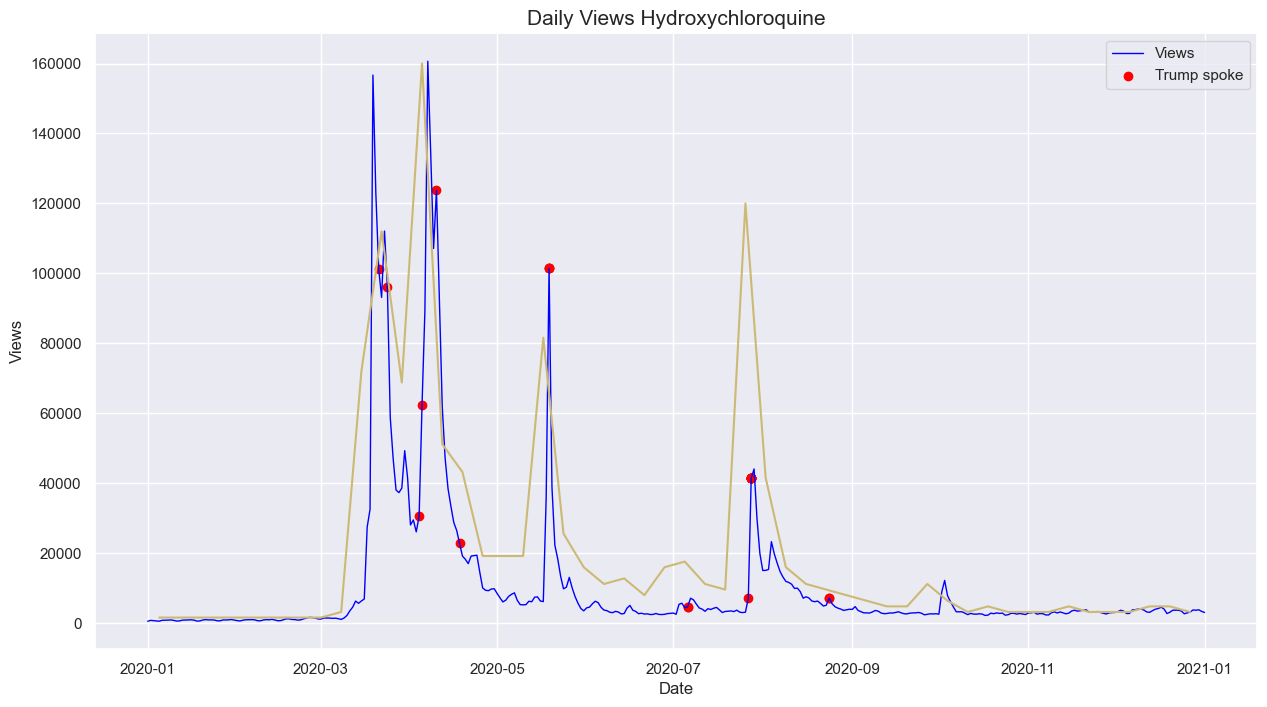

In [174]:
specific_views = views_series.loc[critical_data]

# Plotting the data
plt.plot(views_series, color='blue', linewidth=1)
plt.scatter(specific_views.index, specific_views, color='red')  # Add red dots
plt.plot(trend_df.date, trend_df.value * 1600, color = 'y')
plt.title('Daily Views Hydroxychloroquine', size=15)
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(['Views', 'Trump spoke'])
plt.show()

In [32]:
import os

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_wikipedia.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

command = 'wget -O {saving_path} \'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{page_name}/daily/{start_date}/{end_date}\''\
            .format(saving_path=saving_path, page_name=page_name, start_date=start_date.strftime('%Y%m%d%H'), end_date=end_date.strftime('%Y%m%d%H'))

os.system(command)

1

In [ ]:
# to install: pip install google-search-results

from serpapi import GoogleSearch
import json

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_googletrends.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

params = {
  "engine": "google_trends",
  "q": page_name,
  "data_type": "TIMESERIES",
  "api_key": "dd2b1a64c96847db4dc6d2d2146d7eed59a48a6657355d7a5232f91b1f463f25",
  "date": "{start_date} {end_date}".format(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'))
}

search = GoogleSearch(params)
results = search.get_dict()

json_object = json.dumps(results)
with open(saving_path, 'w') as f:
  f.write(json_object)

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
__Proposition:__ Conduct analyses similar to the above (though briefer) with:
1) Dataset description + preprocessing
2) Visualiation + Granger causality test + (optionally) model training
on the following data:
- tweets/announcements by other ppl
- interventions (restrictions & co, cf Wikidata)
- mobility reports (Apple/Google)

The following part is freely inspired from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [ ]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': True
}

mpl.rcParams.update(params)

In [ ]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

In [ ]:
print(specific_views.index)

DatetimeIndex(['2020-03-24', '2020-04-04', '2020-04-05', '2020-04-10',
               '2020-07-06', '2020-07-28', '2020-07-28'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
# COVID-RELATED PAGEVIEWS
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})

ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

# NON COVID-RELATED PAGEVIEWS

ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
           agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
           agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values,
           adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")

axs[0].plot(views_series/4e6, color='blue', linewidth=1)
axs[0].scatter(specific_views.index, [0.01]*len(specific_views.index), color='red')  # Add red dots
axs[1].plot(views_series*4e3, color='blue', linewidth=1)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')
    
axs[1].scatter(specific_views.index, [2.5e8]*len(specific_views.index), color='red')  # Add red dots

#axs[0].set_title("\% COVID-19-related pageviews \n ($log_{10}$ scale)", pad=35)
axs[1].set_title("Number of pageviews not\n related to COVID-19 ", pad=35)
#axs[2].set_title("Cumulative pageviews difference \n w/ last year (normalized)", pad=35)
#axs[3].set_title("Distance from Normality", pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)

Error in callback <function _draw_all_if_interactive at 0x0000024E0657FEC0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1400x1000 with 3 Axes>